In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model


from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Embedding, Bidirectional, TimeDistributed, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Dropout
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [1]:
pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 52.9 MB/s eta 0:00:00


In [3]:
data = pd.read_csv('data.csv')
data.head()

,counts,smiles,property,value
0,0,[*]CC([*])C,Eat,-5.14
1,1,[*]CC([*])F,Eat,-5.18
2,2,[*]CC([*])(F)F,Eat,-5.21
3,3,[*]C(F)C([*])(F)F,Eat,-5.11
4,4,[*]CCC(F)(F)C([*])(F)F,Eat,-5.21


In [4]:
smiles = data['smiles']
print(smiles)
type(smiles)

0                                      [*]CC([*])C
1                                      [*]CC([*])F
2                                   [*]CC([*])(F)F
3                                [*]C(F)C([*])(F)F
4                           [*]CCC(F)(F)C([*])(F)F
                           ...                    
6260    [*]C(F)(F)C(F)(F)C(S1)=CC=C1C(S2)=CC=C2[*]
6261                    [*]C(F)(F)C(F)(F)C(=O)O[*]
6262          [*]C(F)(F)C(=O)C(F)(F)C(S1)=CC=C1[*]
6263        [*]C(F)(F)C(=O)C(F)(F)C(C=C1)=CC=C1[*]
6264                        [*]C(F)(F)OC(F)(F)O[*]
Name: smiles, Length: 6265, dtype: object


pandas.core.series.Series

In [5]:
# Find the number of missing values
missing_values = data.isnull().sum().sum()
print("Number of missing values:", missing_values)

Number of missing values: 47


In [6]:
# Delete the missing values
data = data.dropna()

In [7]:
# Verify that there are no more missing values
assert data.isnull().sum().sum() == 0

missing_values = data.isnull().sum().sum()

print("No more missing values in the dataset.")
print("Number of missing values:", missing_values)

No more missing values in the dataset.
Number of missing values: 0


In [9]:
def generate_pg_fingerprints(smiles, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    atom_pairs = AllChem.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=nBits)
    topological_torsions = AllChem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=nBits)
    return np.concatenate((atom_pairs, topological_torsions))



In [10]:
data['pg_fp'] = data['smiles'].apply(generate_pg_fingerprints)

In [11]:
print(data['pg_fp'] )

0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
6260    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6261    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6262    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6263    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6264    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: pg_fp, Length: 6218, dtype: object


In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def train_gp_st_model(property_name, data, n_iter=10, cv=3):
    property_data = data[data['property'] == property_name]

    X = np.array(property_data['morgan'].tolist())
    y = property_data['value'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
    gpr = GaussianProcessRegressor(kernel=kernel)

    param_dist = {
        'kernel__k1__length_scale': np.logspace(-2, 3, 1000),
        'kernel__k2__noise_level': np.logspace(-10, 1, 1000)
    }

    search = RandomizedSearchCV(gpr, param_distributions=param_dist, n_iter=n_iter, cv=cv, n_jobs=-1, random_state=42)
    search.fit(X_train_scaled, y_train)

    best_gpr = search.best_estimator_
    y_pred = best_gpr.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse


In [13]:
property_names = ['Eat', 'Xc', 'Egc', 'Egb', 'Eea', 'Ei', 'nc', 'eps']
rmse_values = []

for property_name in property_names:
    rmse = train_gp_st_model(property_name, data)
    rmse_values.append(rmse)
    print(f'Property: {property_name}, RMSE: {rmse}')


Property: Eat, RMSE: 0.3011920320143522


/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Property: Xc, RMSE: 22.575110221464726
Property: Egc, RMSE: 0.7392987228638096
Property: Egb, RMSE: 1.6985893104244216
Property: Eea, RMSE: 0.669501681366255
Property: Ei, RMSE: 0.6636157439621323
Property: nc, RMSE: 0.1811347883126609
Property: eps, RMSE: 1.0436960975197518


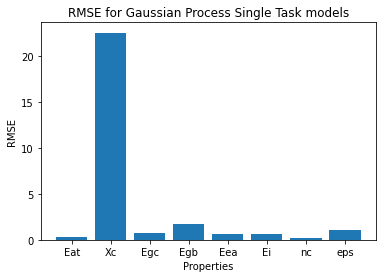

In [14]:
# Plot RMSE values for all properties
plt.bar(property_names, rmse_values)
plt.xlabel("Properties")
plt.ylabel("RMSE")
plt.title("RMSE for Gaussian Process Single Task models")
plt.show()


In [15]:
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import uniform, randint


In [16]:
def train_evaluate_svr_st(data, property_name, cv=5):
    property_data = data[data['property'] == property_name]

    X = np.array(property_data['morgan'].tolist())
    y = property_data['value'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    param_dist = {
        'C': uniform(loc=0.1, scale=10),
        'epsilon': uniform(loc=0.01, scale=1),
        'kernel': ['linear', 'rbf']
    }

    svr = SVR()
    random_search = RandomizedSearchCV(svr, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
    random_search.fit(X_train_scaled, y_train)

    best_svr = random_search.best_estimator_
    y_pred = best_svr.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse


Property: Eat, RMSE: 0.16217344021075938
Property: Xc, RMSE: 19.815718295157524
Property: Egc, RMSE: 0.7582039670057363
Property: Egb, RMSE: 1.1658819995380252
Property: Eea, RMSE: 0.5017225976488133
Property: Ei, RMSE: 0.5872092749270256
Property: nc, RMSE: 0.1472140183891133
Property: eps, RMSE: 0.7717001223973871


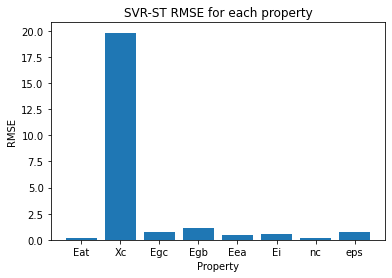

In [17]:
property_names = ['Eat', 'Xc', 'Egc', 'Egb', 'Eea', 'Ei', 'nc', 'eps']
rmse_values = []

for property_name in property_names:
    rmse = train_evaluate_svr_st(data, property_name)
    rmse_values.append(rmse)
    print(f'Property: {property_name}, RMSE: {rmse}')
    
plt.bar(property_names, rmse_values)
plt.xlabel('Property')
plt.ylabel('RMSE')
plt.title('SVR-ST RMSE for each property')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, PReLU
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def create_nn_model(hidden_layer1=480, hidden_layer2=224, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(hidden_layer1, input_dim=2048, activation=None))
    model.add(PReLU())
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_layer2, activation=None))
    model.add(PReLU())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=None))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
nn_regressor = KerasRegressor(build_fn=create_nn_model, epochs=100, batch_size=32, verbose=0)
param_dist = {
    'hidden_layer1': [400, 480, 560],
    'hidden_layer2': [200, 224, 248],
    'dropout_rate': [0.4, 0.5, 0.6]
}

In [ ]:
property_names = ['Eat', 'Xc', 'Egc', 'Egb', 'Eea', 'Ei', 'nc', 'eps']
rmse_scores = []

for property_name in property_names:
    print(f"Training model for property: {property_name}")
    property_data = data[data['property'] == property_name]

    X = np.array(property_data['morgan'].tolist())
    y = property_data['value'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    random_search = RandomizedSearchCV(estimator=nn_regressor, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X_train_scaled, y_train)

    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    print(f"RMSE for {property_name}: {rmse:.4f}")

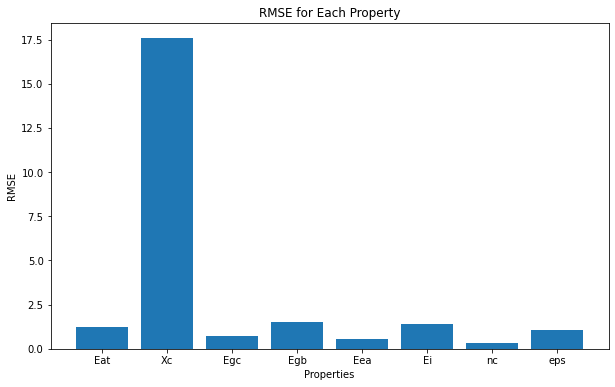

In [21]:
plt.figure(figsize=(10, 6))
plt.bar(property_names, rmse_scores)
plt.xlabel('Properties')
plt.ylabel('RMSE')
plt.title('RMSE for Each Property')
plt.show()


In [26]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LeakyReLU
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

property_names = ['Eat', 'Xc', 'Egc', 'Egb', 'Eea', 'Ei', 'nc', 'eps']
property_data = {property_name: data[data['property'] == property_name] for property_name in property_names}

def create_base_model(hidden_layers, neurons, dropout_rate):
    inputs = Input(shape=(2048,))
    x = inputs
    for i in range(hidden_layers):
        x = Dense(neurons, activation='linear')(x)
        x = LeakyReLU(alpha=0.3)(x)
        x = Dropout(dropout_rate)(x)
    
    outputs = [Dense(1, activation='linear', name=f'output_{property_name}')(x) for property_name in property_names]
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

# Set up the parameters for the RandomizedSearchCV
param_dist = {
    'hidden_layers': [1, 2, 3],
    'neurons': [480, 416],
    'dropout_rate': [0.5],
}

regressor = KerasRegressor(build_fn=create_base_model, epochs=100, batch_size=32, verbose=0)
random_search = RandomizedSearchCV(estimator=regressor, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1, random_state=42)

# Train the model and optimize hyperparameters
property_models = {}
for property_name in property_names:
    print(f'Training property: {property_name}')
    X = np.array(property_data[property_name]['morgan'].tolist())
    y = property_data[property_name]['value'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    random_search.fit(X_train_scaled, y_train)
    best_params = random_search.best_params_
    print(f'Best parameters for {property_name}: {best_params}')
    
    model = create_base_model(**best_params)
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)
    
    property_models[property_name] = model

rmse_scores = []




<ipython-input-26-0f2ef7ceec79>:33: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn=create_base_model, epochs=100, batch_size=32, verbose=0)


Training property: Eat


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Eat: {'neurons': 416, 'hidden_layers': 3, 'dropout_rate': 0.5}
Training property: Xc


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Xc: {'neurons': 480, 'hidden_layers': 3, 'dropout_rate': 0.5}
Training property: Egc


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for Egc: {'neurons': 480, 'hidden_layers': 3, 'dropout_rate': 0.5}
Training property: Egb


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Egb: {'neurons': 480, 'hidden_layers': 3, 'dropout_rate': 0.5}
Training property: Eea


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Eea: {'neurons': 416, 'hidden_layers': 3, 'dropout_rate': 0.5}
Training property: Ei


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Ei: {'neurons': 416, 'hidden_layers': 3, 'dropout_rate': 0.5}
Training property: nc


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for nc: {'neurons': 416, 'hidden_layers': 3, 'dropout_rate': 0.5}
Training property: eps


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for eps: {'neurons': 480, 'hidden_layers': 3, 'dropout_rate': 0.5}
3/3 [==============================] - 0s 8ms/step


TypeError: ignored

In [1]:
rmse_scores = []

for property_name, model in property_models.items():
    X = np.array(property_data[property_name]['morgan'].tolist())
    y = property_data[property_name]['value'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    y_pred = model.predict(X_test_scaled)[:, 0]
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)
    print(f'RMSE for {property_name}: {rmse}')

# Plot the RMSE for each property
plt.figure(figsize=(10, 6))
plt.bar(property_names, rmse_scores)
plt.xlabel('Property')
plt.ylabel('RMSE')
plt.title('RMSE for each property')
plt.show()

NameError: ignored